This tutorial will walk you through how to perform basic supervised machine learning (ML) tasks on different types of data that might be relevent for various scientific applications. First we must generate some representative data.

# Generating Data

First, we will generate some nonlinear multi-variate data that will serve as a sufficiently challenging test case for our ML model. The Scikit-Learn library offers some generic routines for generating synthetic data suitable for a range of ML tasks for testing purposes.

In [1]:
# Import the sklearn datasets
import sklearn.datasets as sdt
# Other imports
import numpy as np
import matplotlib.pyplot as plt

For this first example, we will use the Friedman #1 regression function which takes the form: $$f(x)=10sin(\pi x_1 x_2)+ 20(x_3−0.5)^2+10x_4 + 5x_5+ N(0,\sigma) $$

In the following distribution we will create output with 9 features despite the Friedman #1 function only depending upon the first 5 features.

In [2]:
# Create a non-linear distribution using the Friedman #1 function
n_samples = 1000
n_feats = 10
x, y = sdt.make_friedman1(
        n_samples=n_samples,
        n_features=n_feats,
        noise=0.0,
        random_state=42,
)
y = np.expand_dims(y, axis=1)
print(x.shape, y.shape)

(1000, 10) (1000, 1)


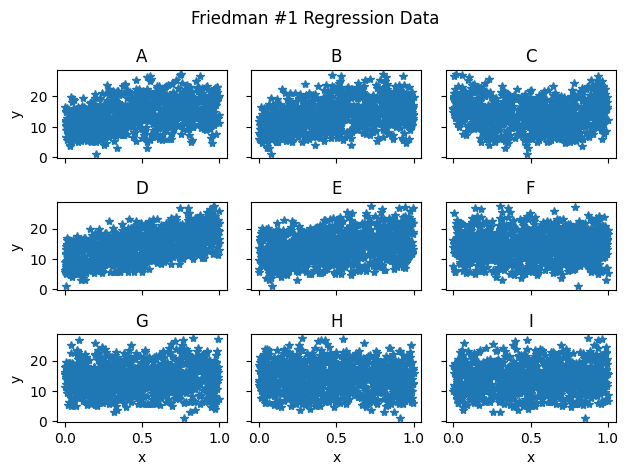

In [3]:
# Visualize the data using a mosaic plot
mosaic = [['A', 'B', 'C'],
          ['D', 'E', 'F'],
          ['G', 'H', 'I']]
fig, axdict = plt.subplot_mosaic(mosaic, sharex=True, sharey=True)
# Loop over all the labels in the mosaic
for idx, ilabel in enumerate(axdict.keys()):
    axdict[ilabel].plot(x[:,idx], y, marker="*", linestyle="None")
    # Set some plot labels
    axdict[ilabel].set_title(ilabel)
    if ilabel in ['A', 'D', 'G']:
        axdict[ilabel].set_ylabel("y")
    if ilabel in ['G', 'H', 'I']:
        axdict[ilabel].set_xlabel("x")

fig.suptitle('Friedman #1 Regression Data')
fig.tight_layout()
plt.show()

# Preprocessing the data
Most ML problems optimally operate on data that is normalized. The type optimal type of normalization depends upon the structure of the data and the desired output.

For this data we will use a rather standard that shifts and scales the data to a distribution centered around 0 with standard deviation equal to 1.

$$ x' = \frac{x - \sigma(x)}{\sqrt{\sigma(x)^2}}$$

We can do this manually, or use a built in function provided as a part of TensorFlow. It is often usefull to also create an inverse normalization function which can be used to convert the ML model predictions back to the physical space.

In [4]:
# Import tensorflow and Normalization layer
import tensorflow as tf
from tensorflow.keras.layers import Normalization

# Create the normalizing function for x and y
normalizer_x = Normalization()
normalizer_y = Normalization()
# Create the inverse normalizing function
inv_normalizer_x = Normalization(invert=True)
inv_normalizer_y = Normalization(invert=True)

# Adapt the normalization layers to the data we created
normalizer_x.adapt(x)
inv_normalizer_x.adapt(x)
normalizer_y.adapt(y)
inv_normalizer_y.adapt(y)

# Now, create scale the data using the normalizers
x_norm = normalizer_x(x)
y_norm = normalizer_y(y)

2023-10-13 14:59:26.759278: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


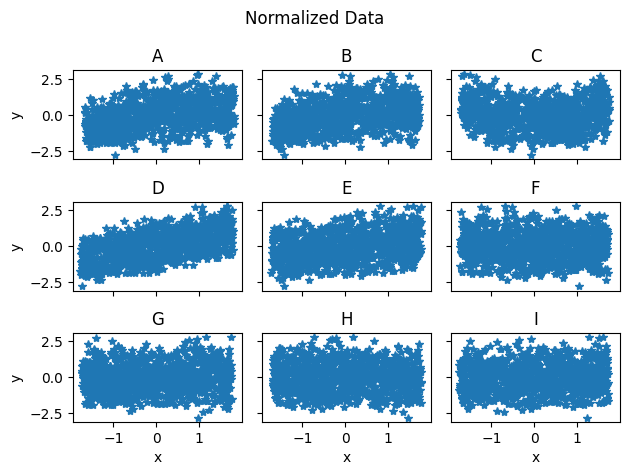

In [5]:
# Visualize the data using a mosaic plot
mosaic = [['A', 'B', 'C'],
          ['D', 'E', 'F'],
          ['G', 'H', 'I']]
fig, axdict = plt.subplot_mosaic(mosaic, sharex=True, sharey=True)
# Loop over all the labels in the mosaic
for idx, ilabel in enumerate(axdict.keys()):
    axdict[ilabel].plot(x_norm[:,idx], y_norm, marker="*", linestyle="None")
    # Set some plot labels
    axdict[ilabel].set_title(ilabel)
    if ilabel in ['A', 'D', 'G']:
        axdict[ilabel].set_ylabel("y")
    if ilabel in ['G', 'H', 'I']:
        axdict[ilabel].set_xlabel("x")

fig.suptitle('Normalized Data')
fig.tight_layout()
plt.show()

# Creating a ML Model
Now that the data is preprocessed nicely, let's create a standard feed-forward neural network and train it to learn the relationship between the features (x) and the output (y).

The initial model will be have an input layer, three hidden layer with 64 neurons, and an output layer. The number of hidden layers, neurons per layer, and a variety of other so-called "hyperparameters" will have a noticable impact on model results. These values require extensive tuning depending on the problem at hand.

In [6]:
# Import tensorflow layers
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
# from tensorflow.keras.utils import plot_model

# Form the model using TensorFlow functional form
# Input layer is the same width as the number of features
inputs = Input(shape=(None, n_feats))
# Hidden layer with 64 neurons and relu activation
xtmp = Dense(64, activation='relu')(inputs)
# A second hidden layer with 64 neurons and relu activation
xtmp = Dense(64, activation='relu')(xtmp)
# A third hidden layer with 64 neurons and relu activation
xtmp = Dense(64, activation='relu')(xtmp)
# Output layer with 1 neuron because there is only 1 output feature
xout = Dense(1, activation=None)(xtmp)

# Define the model
model = Model(inputs=inputs, outputs=xout)

model.summary()
# plot_model(model, show_shapes=True)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 10)]        0         
                                                                 
 dense (Dense)               (None, None, 64)          704       
                                                                 
 dense_1 (Dense)             (None, None, 64)          4160      
                                                                 
 dense_2 (Dense)             (None, None, 64)          4160      
                                                                 
 dense_3 (Dense)             (None, None, 1)           65        
                                                                 
Total params: 9089 (35.50 KB)
Trainable params: 9089 (35.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
# Now, we compile the model with Adam optimizer
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer)

In [8]:
# Generate train and validation datasets with 80-20 split
train_data, val_data = np.split(np.concatenate((x_norm, y_norm), axis=1), [int(0.8 * x_norm.shape[0])])
x_train, y_train = train_data[:, :n_feats], train_data[:, -1].reshape(-1, 1)
x_val, y_val  = val_data[:, :n_feats], val_data[:, -1].reshape(-1, 1)

# precompute the unnormalized versions of y
y_train_real = inv_normalizer_y(y_train).numpy()
y_val_real = inv_normalizer_y(y_val).numpy()

# Now we can train the model
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=100,
    batch_size=32,
)

Epoch 1/100
25/25 [==============================] - 1s 7ms/step - loss: 0.7885 - val_loss: 0.4726
Epoch 2/100
25/25 [==============================] - 0s 2ms/step - loss: 0.3336 - val_loss: 0.3212
Epoch 3/100
25/25 [==============================] - 0s 2ms/step - loss: 0.2131 - val_loss: 0.2420
Epoch 4/100
25/25 [==============================] - 0s 2ms/step - loss: 0.1569 - val_loss: 0.1983
Epoch 5/100
25/25 [==============================] - 0s 2ms/step - loss: 0.1216 - val_loss: 0.1672
Epoch 6/100
25/25 [==============================] - 0s 2ms/step - loss: 0.0925 - val_loss: 0.1471
Epoch 7/100
25/25 [==============================] - 0s 2ms/step - loss: 0.0790 - val_loss: 0.1259
Epoch 8/100
25/25 [==============================] - 0s 2ms/step - loss: 0.0646 - val_loss: 0.1153
Epoch 9/100
25/25 [==============================] - 0s 2ms/step - loss: 0.0553 - val_loss: 0.1091
Epoch 10/100
25/25 [==============================] - 0s 2ms/step - loss: 0.0504 - val_loss: 0.0971
Epoch 11/

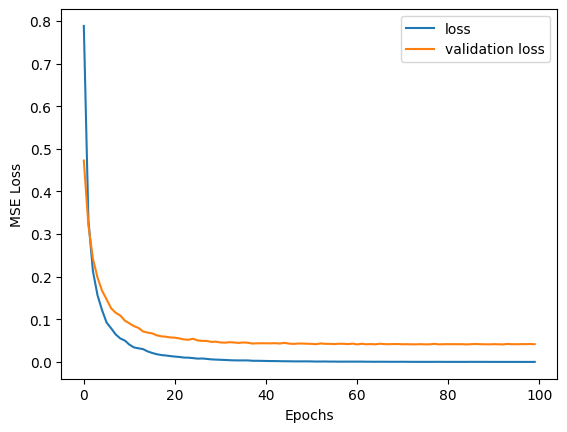

In [9]:
# Plot the loss function over time
fig, ax = plt.subplots(1, 1)
ax.plot(history.history["loss"], label="loss")
ax.plot(history.history["val_loss"], label="validation loss")
ax.legend()
ax.set_xlabel("Epochs")
ax.set_ylabel("MSE Loss")
plt.show()

In [10]:
# Evaluate the model performance on train and validation data
pred_norm = model.predict(x_norm)
pred_norm_train = model.predict(x_train)
pred_norm_val = model.predict(x_val)

# Unscale the results and plot
pred_full = inv_normalizer_y(pred_norm).numpy()
pred_train = inv_normalizer_y(pred_norm_train).numpy()
pred_val = inv_normalizer_y(pred_norm_val).numpy()

7/7 [==============================] - 0s 1ms/step


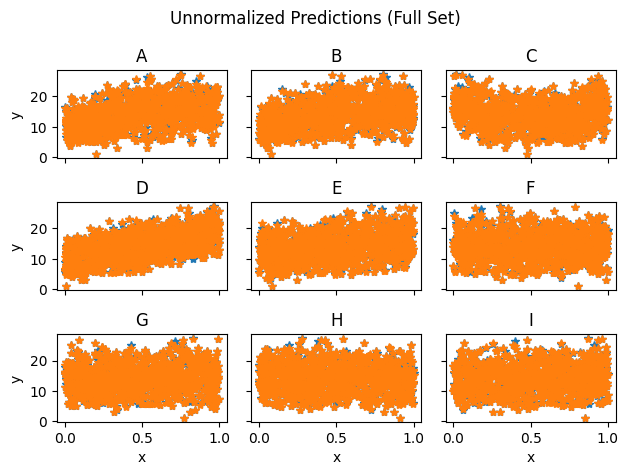

In [11]:
# Visualize the data using a mosaic plot
mosaic = [['A', 'B', 'C'],
          ['D', 'E', 'F'],
          ['G', 'H', 'I']]
fig, axdict = plt.subplot_mosaic(mosaic, sharex=True, sharey=True)
# Loop over all the labels in the mosaic
for idx, ilabel in enumerate(axdict.keys()):
    axdict[ilabel].plot(x[:,idx], y, marker="*", linestyle="None", label="truth")
    axdict[ilabel].plot(x[:,idx], pred_full, marker="*", linestyle="None", label="pred")
    # Set some plot labels
    axdict[ilabel].set_title(ilabel)
    if ilabel in ['A', 'D', 'G']:
        axdict[ilabel].set_ylabel("y")
    if ilabel in ['G', 'H', 'I']:
        axdict[ilabel].set_xlabel("x")

fig.suptitle('Unnormalized Predictions (Full Set)')
fig.tight_layout()
plt.show()

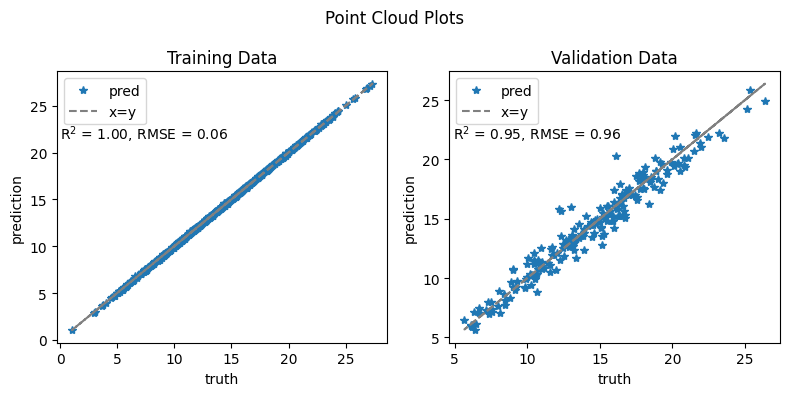

In [12]:
# Compute some statistics on the fit
from sklearn.metrics import mean_squared_error
def pred_stats(pred, truth):
    rss = np.sum((pred - truth) ** 2)
    tss = np.sum((truth - np.mean(truth)) ** 2)
    r_sq = 1 - rss / tss
    rmse = np.sqrt(mean_squared_error(truth, pred))
    return r_sq, rmse
    
# Training data
r_sq_train, rmse_train = pred_stats(pred_train, y_train_real)
r_sq_val, rmse_val = pred_stats(pred_val, y_val_real)

# Visualize the predictions using a cloud plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
# Train plot
ax1.plot(y_train_real, pred_train, marker="*", linestyle="None", label="pred")
ax1.plot(y_train_real, y_train_real, linestyle="dashed", label="x=y", color="grey")
ax1.text(x=0.01, y=0.75, s=rf"R$^2$ = {r_sq_train:0.2f}, RMSE = {rmse_train:0.2f}", transform=ax1.transAxes)
ax1.legend()
ax1.set_xlabel("truth")
ax1.set_ylabel("prediction")
ax1.set_title("Training Data")
# Validation plot
ax2.plot(y_val_real, pred_val, marker="*", linestyle="None", label="pred")
ax2.plot(y_val_real, y_val_real, linestyle="dashed", label="x=y", color="grey")
ax2.text(x=0.01, y=0.75, s=rf"R$^2$ = {r_sq_val:0.2f}, RMSE = {rmse_val:0.2f}", transform=ax2.transAxes)
ax2.legend()
ax2.set_xlabel("truth")
ax2.set_ylabel("prediction")
ax2.set_title("Validation Data")

fig.suptitle('Point Cloud Plots')
fig.tight_layout()
plt.show()

# Using TF-MELT
We have so far shown how to get started with the basics of initializing, training, and testing a model using TensorFlow basics. While this is important to know, there are many different ML architectures that, along with hyperparameters, can have a larger impact on model results and accuracy. Some architectures are better suited to problems than others, and it can oftentimes involve a great deal of trial-and-error to figure out which ML architectures are best for a given dataset and desired outcomes.

To spead up the process of ML architecture discovery and hyperparamter experimentation, the AI/ML team at NREL has developed a toolbox for TensorFlow that allows for the streamlined implementation of a number of commonly used ML architectures. Here we will show how to get started with TF-MELT. We start by pip installing the TF-MELT repository and importing the ArtificialNeuralNetwork (ANN) architecture.

In [13]:
pip install git+https://github.com/NREL/tf-melt.git@tf_214_hotfix

  Cloning https://github.com/NREL/tf-melt.git (to revision tf_214_hotfix) to /private/var/folders/jb/yy7lxgjd6915xnjb4_b6npk05gvryg/T/pip-req-build-k73wrrlk
  Running command git clone --filter=blob:none --quiet https://github.com/NREL/tf-melt.git /private/var/folders/jb/yy7lxgjd6915xnjb4_b6npk05gvryg/T/pip-req-build-k73wrrlk
  Running command git checkout -b tf_214_hotfix --track origin/tf_214_hotfix
  Switched to a new branch 'tf_214_hotfix'
  branch 'tf_214_hotfix' set up to track 'origin/tf_214_hotfix'.
  Resolved https://github.com/NREL/tf-melt.git to commit c38c556ff7097369d0253fe47e00db46a6327d1e
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [14]:
# Import the TF-MELT architecture
from tfmelt.models import ArtificialNeuralNetwork

In [15]:
# Initialize the model
model = ArtificialNeuralNetwork(
    num_feat=n_feats,
    num_outputs=1,
    width=64,
    depth=1,
    act_fun="relu",
)
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="mse",
    run_eagerly=False,
)

In [16]:
# Now we can train the model
history = model.fit(
    x_train,
    y_train,
    validation_data = (x_val, y_val),
    epochs=100,
    batch_size=32,
)

Epoch 1/100
25/25 [==============================] - 1s 7ms/step - loss: 0.8512 - val_loss: 0.4947
Epoch 2/100
25/25 [==============================] - 0s 3ms/step - loss: 0.3487 - val_loss: 0.3111
Epoch 3/100
25/25 [==============================] - 0s 2ms/step - loss: 0.2231 - val_loss: 0.2376
Epoch 4/100
25/25 [==============================] - 0s 2ms/step - loss: 0.1721 - val_loss: 0.2003
Epoch 5/100
25/25 [==============================] - 0s 2ms/step - loss: 0.1295 - val_loss: 0.1591
Epoch 6/100
25/25 [==============================] - 0s 2ms/step - loss: 0.1017 - val_loss: 0.1275
Epoch 7/100
25/25 [==============================] - 0s 2ms/step - loss: 0.0726 - val_loss: 0.1011
Epoch 8/100
25/25 [==============================] - 0s 2ms/step - loss: 0.0554 - val_loss: 0.0881
Epoch 9/100
25/25 [==============================] - 0s 2ms/step - loss: 0.0458 - val_loss: 0.0750
Epoch 10/100
25/25 [==============================] - 0s 2ms/step - loss: 0.0351 - val_loss: 0.0691
Epoch 11/

In [17]:
model.summary()

Model: "artificial_neural_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           multiple                  0 (unused)
                                                                 
 input_dropout (Dropout)     multiple                  0 (unused)
                                                                 
 batch_norm (BatchNormaliza  multiple                  0 (unused)
 tion)                                                           
                                                                 
 input2bulk (Dense)          multiple                  704       
                                                                 
 bulk_0 (Dense)              multiple                  4160      
                                                                 
 bulk2output (Dense)         multiple                  4160      
                                         

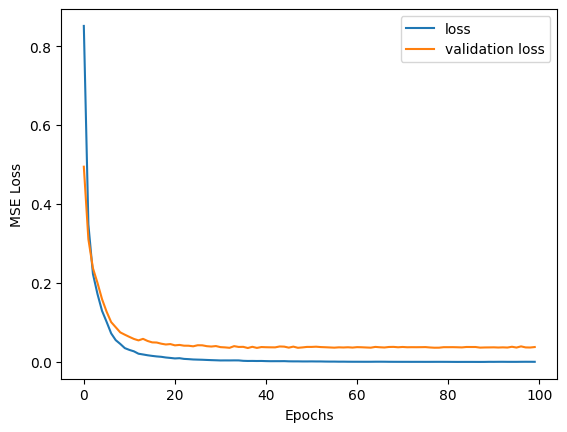

In [18]:
# Plot the loss function over time
fig, ax = plt.subplots(1, 1)
ax.plot(history.history["loss"], label="loss")
ax.plot(history.history["val_loss"], label="validation loss")
ax.legend()
ax.set_xlabel("Epochs")
ax.set_ylabel("MSE Loss")
plt.show()

In [19]:
# Evaluate the model performance on train and validation data
pred_norm = model.predict(x_norm)
pred_norm_train = model.predict(x_train)
pred_norm_val = model.predict(x_val)

# Unscale the results and plot
pred_full = inv_normalizer_y(pred_norm).numpy()
pred_train = inv_normalizer_y(pred_norm_train).numpy()
pred_val = inv_normalizer_y(pred_norm_val).numpy()

7/7 [==============================] - 0s 990us/step


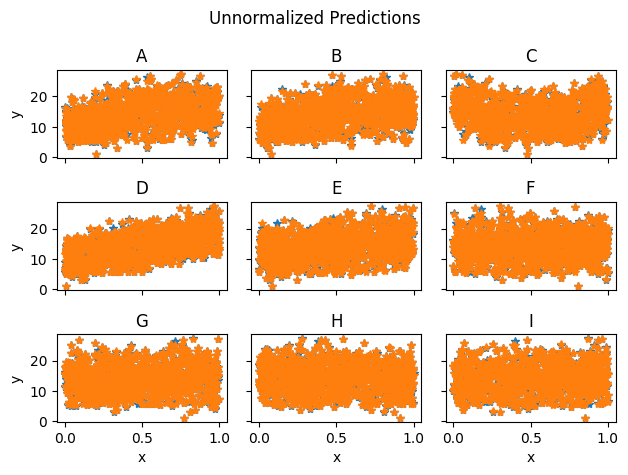

In [20]:
# Visualize the data using a mosaic plot
mosaic = [['A', 'B', 'C'],
          ['D', 'E', 'F'],
          ['G', 'H', 'I']]
fig, axdict = plt.subplot_mosaic(mosaic, sharex=True, sharey=True)
# Loop over all the labels in the mosaic
for idx, ilabel in enumerate(axdict.keys()):
    axdict[ilabel].plot(x[:,idx], y, marker="*", linestyle="None", label="truth")
    axdict[ilabel].plot(x[:,idx], pred_full, marker="*", linestyle="None", label="pred")
    # Set some plot labels
    axdict[ilabel].set_title(ilabel)
    if ilabel in ['A', 'D', 'G']:
        axdict[ilabel].set_ylabel("y")
    if ilabel in ['G', 'H', 'I']:
        axdict[ilabel].set_xlabel("x")

fig.suptitle('Unnormalized Predictions')
fig.tight_layout()
plt.show()

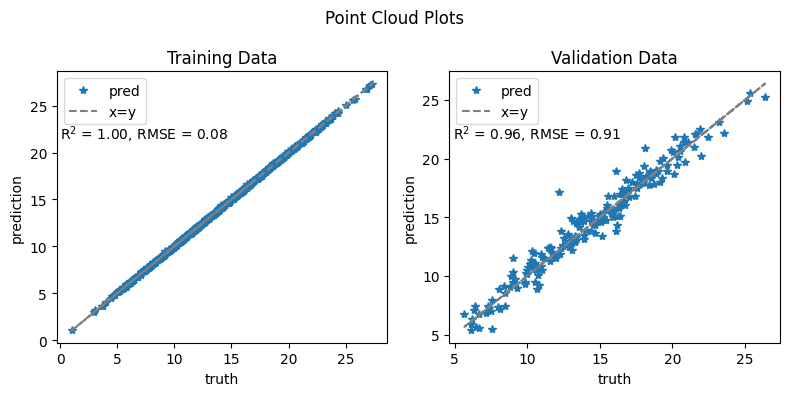

In [21]:
# Compute some statistics on the fit

# Training data
r_sq_train, rmse_train = pred_stats(pred_train, y_train_real)
r_sq_val, rmse_val = pred_stats(pred_val, y_val_real)

# Visualize the predictions using a cloud plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
# Train plot
ax1.plot(y_train_real, pred_train, marker="*", linestyle="None", label="pred")
ax1.plot(y_train_real, y_train_real, linestyle="dashed", label="x=y", color="grey")
ax1.text(x=0.01, y=0.75, s=rf"R$^2$ = {r_sq_train:0.2f}, RMSE = {rmse_train:0.2f}", transform=ax1.transAxes)
ax1.legend()
ax1.set_xlabel("truth")
ax1.set_ylabel("prediction")
ax1.set_title("Training Data")
# Validation plot
ax2.plot(y_val_real, pred_val, marker="*", linestyle="None", label="pred")
ax2.plot(y_val_real, y_val_real, linestyle="dashed", label="x=y", color="grey")
ax2.text(x=0.01, y=0.75, s=rf"R$^2$ = {r_sq_val:0.2f}, RMSE = {rmse_val:0.2f}", transform=ax2.transAxes)
ax2.legend()
ax2.set_xlabel("truth")
ax2.set_ylabel("prediction")
ax2.set_title("Validation Data")

fig.suptitle('Point Cloud Plots')
fig.tight_layout()
plt.show()

# Exploration
Here we can see that we have the same results from the model that we built using base TensorFlow and the model that we imported from TF-MELT. Now, let's look an example of how using a generalized tool like TF-MELT can assist in the rapid exploration of architecture parameter space which is often useful when determining optimal settings for machine learning tasks.

## Model Depth
Let's look at the impact of different sets of layers in the neural networks. Here we will define different models and compare the results. The following example would typically require implementation of separate ML models, but using TF-MELT we can rapidly perform the parameter sweep with just a couple simple `for` loops.

In [22]:
# Define a vector of different depths to test
depth_vec = [0, 2, 4]
# Loop over the depth vector, create the ANNs, and view the model structure
model_dict = {}
for depth in depth_vec:
    model_dict[depth] = ArtificialNeuralNetwork(
        num_feat=n_feats,
        num_outputs=1,
        width=64,
        depth=depth,
        act_fun="relu",
    )
    # Initialize a generic optimizer
    optimizer = Adam(learning_rate=1e-3) # NOTE: This value will be changed during "Learning Rate Exploration"
    # Compile the models
    model_dict[depth].compile(
        optimizer=optimizer,
        loss="mse",
        run_eagerly=False,
    )
    model_dict[depth].build(input_shape=(None, n_feats))
    model_dict[depth].summary()

Model: "artificial_neural_network_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           multiple                  0 (unused)
                                                                 
 input_dropout (Dropout)     multiple                  0 (unused)
                                                                 
 batch_norm (BatchNormaliza  multiple                  0 (unused)
 tion)                                                           
                                                                 
 input2bulk (Dense)          multiple                  704       
                                                                 
 bulk2output (Dense)         multiple                  4160      
                                                                 
 output (Dense)              multiple                  65        
                                       

Using the above TF-MELT structure we can easily create a range of models with different numbers of bulk hidden layers for testing. We can likewise train and evaluate as well.

In [23]:
history = {}
for depth in depth_vec:
    print(f"Training ANN with depth = {depth}")
    history[depth] = model_dict[depth].fit(
        x_train,
        y_train,
        validation_data=(x_val, y_val),
        epochs=100,
        batch_size=32,
    )

Training ANN with depth = 0
Epoch 1/100
25/25 [==============================] - 1s 6ms/step - loss: 0.8602 - val_loss: 0.4834
Epoch 2/100
25/25 [==============================] - 0s 2ms/step - loss: 0.3580 - val_loss: 0.3035
Epoch 3/100
25/25 [==============================] - 0s 2ms/step - loss: 0.2338 - val_loss: 0.2594
Epoch 4/100
25/25 [==============================] - 0s 3ms/step - loss: 0.1915 - val_loss: 0.2263
Epoch 5/100
25/25 [==============================] - 0s 2ms/step - loss: 0.1622 - val_loss: 0.2007
Epoch 6/100
25/25 [==============================] - 0s 2ms/step - loss: 0.1376 - val_loss: 0.1748
Epoch 7/100
25/25 [==============================] - 0s 2ms/step - loss: 0.1174 - val_loss: 0.1531
Epoch 8/100
25/25 [==============================] - 0s 2ms/step - loss: 0.0973 - val_loss: 0.1356
Epoch 9/100
25/25 [==============================] - 0s 2ms/step - loss: 0.0823 - val_loss: 0.1229
Epoch 10/100
25/25 [==============================] - 0s 2ms/step - loss: 0.0705 

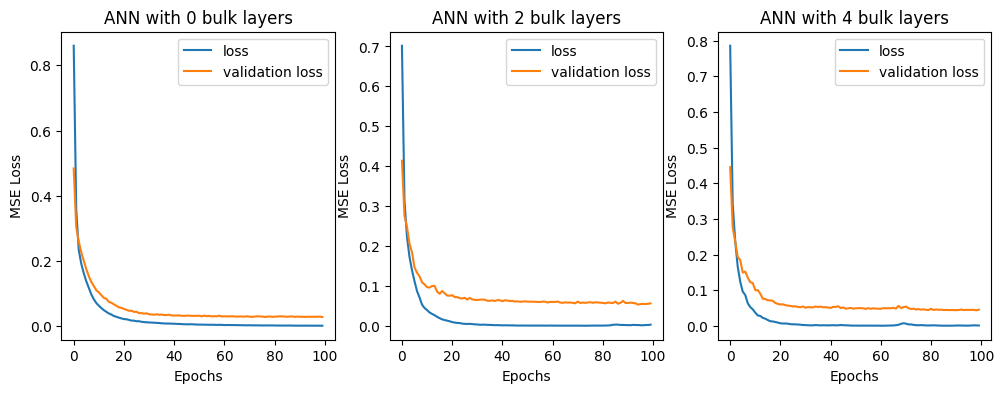

In [24]:
fig, axs = plt.subplots(1, len(depth_vec), figsize=(4*len(depth_vec), 4))
for idx, depth in enumerate(depth_vec):
    axs[idx].plot(history[depth].history["loss"], label="loss")
    axs[idx].plot(history[depth].history["val_loss"], label="validation loss")
    axs[idx].legend()
    axs[idx].set_xlabel("Epochs")
    axs[idx].set_ylabel("MSE Loss")
    axs[idx].set_title(f"ANN with {depth} bulk layers")
    
plt.show()

7/7 [==============================] - 0s 956us/step


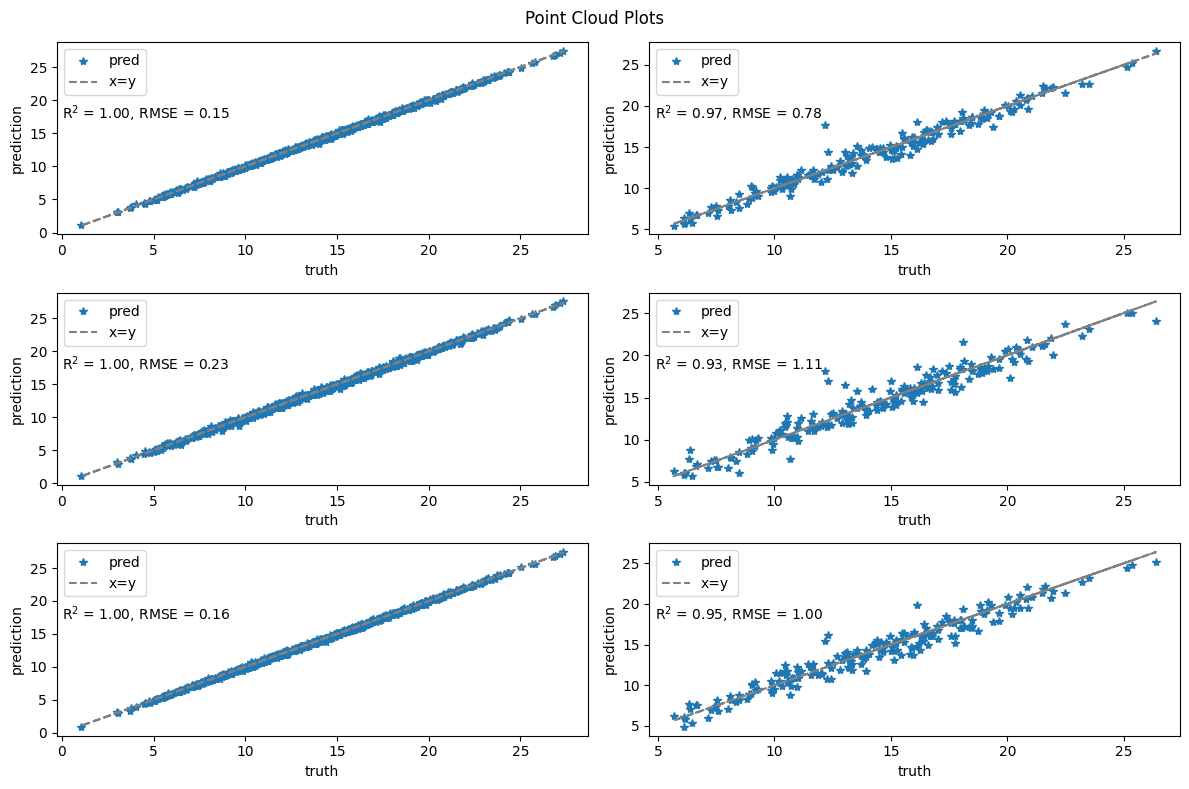

In [25]:
fig, axs = plt.subplots(len(depth_vec), 2, figsize=(4*len(depth_vec), 4*2))
# Evaluate the model performance
for idx, depth in enumerate(depth_vec):
    pred_norm_train = model_dict[depth].predict(x_train)
    pred_norm_val = model_dict[depth].predict(x_val)
    
    # Unscale the results and plot
    pred_train = inv_normalizer_y(pred_norm_train).numpy()
    pred_val = inv_normalizer_y(pred_norm_val).numpy()

    # Compute some statistics on the fit
    # rss = np.sum((pred - y) ** 2)
    # tss = np.sum((y - np.mean(y)) ** 2)
    # r_sq = 1 - rss / tss
    # rmse = np.sqrt(mean_squared_error(y, pred))
    r_sq_train, rmse_train = pred_stats(pred_train, y_train_real)
    r_sq_val, rmse_val = pred_stats(pred_val, y_val_real)
    # Visualize the predictions using a cloud plot
    ax0 = axs[idx, 0]
    ax1 = axs[idx, 1]
    # Training data
    ax0.plot(y_train_real, pred_train, marker="*", linestyle="None", label="pred")
    ax0.plot(y_train_real, y_train_real, linestyle="dashed", label="x=y", color="grey")
    ax0.text(x=0.01, y=0.60, s=rf"R$^2$ = {r_sq_train:0.2f}, RMSE = {rmse_train:0.2f}", transform=ax0.transAxes)
    ax0.legend()
    ax0.set_xlabel("truth")
    ax0.set_ylabel("prediction")
    # Validation data
    ax1.plot(y_val_real, pred_val, marker="*", linestyle="None", label="pred")
    ax1.plot(y_val_real, y_val_real, linestyle="dashed", label="x=y", color="grey")
    ax1.text(x=0.01, y=0.60, s=rf"R$^2$ = {r_sq_val:0.2f}, RMSE = {rmse_val:0.2f}", transform=ax1.transAxes)
    ax1.legend()
    ax1.set_xlabel("truth")
    ax1.set_ylabel("prediction")
    
fig.suptitle('Point Cloud Plots')
fig.tight_layout()
plt.show()

# Observations
Here we can observe an interesing behaviour between the results of the models with different number of bulk layers. The results appear to get worse as the number of hidden layers increases. This is counter-intuitive as one would expect the results to improve as the number of free parameters increases to approximate the data. A clue to explain this behavior lies in the loss plots above. We can see that there is an increasing gap between the training dataset loss and the validation dataset loss as the number of layers increases. This is a classic example of overfitting to the training data which tends to reduce performance on the valiation dataset.

# Learning Rate Exploration
Go back up to the `Exploration` section, change the learning rate to 1e-4 and re-run the following cells. Observe the behavior of the loss curves. Try an even smaller learning rate (ex. 3e-5). You might also want to increase the number of training epochs as the learning rate is decreased.

These series of runs demonstrate that the results of the model predictions is tied to the joint selection of hyperparameters and the model architecture. These values need to be tuned with the choice of ML architecture and if the architecture is changed, the hyperparameters will likely need to be re-adjusted to ensure acceptable performance.

As a final point, adding more layers to a model is not always the best answer for increasing the performance of ML models. The key to improving ML model results is often tied to a better understanding of the underlying data.

Hyperparameter tuning and ML best practices will be the subject of another tutorial.